# IACAH (India Academia Connect AI Hackathon)

Date - October 4-13, 2021

Artificial intelligence will be an enormous part of the future workforce. It’s expected to generate 2 million net job gains versus losses by 2025. India Academia Connect AI Hackathon will help the participants from leading research institutions with the opportunity to learn and implement the latest AI technology, preparing them for a future AI-powered economy, with a large research and developer base.

Data Download Link:- [GDrive Link](https://drive.google.com/drive/folders/1O8TT0s4zMyiI6zR-biVRoiLiAUy-W1H0?usp=sharing)

#### Primary Goal:- To classify the Images into Background and Text
    To Classify the Images into two categories(Background or Text) using Tensorflow and Keras.

#### Solution:- 
    It's a Binary Class classification problem. It can be solved using CNN classifier.
    Train the Model using transfer learning. We used VGG16 as feature extractor and used Dropout to avoid overfitting. we used some ImageDataAugmentation technique to make model more robust and better. we are using modelcheckpoint and earlystopping callbacks function to get the best model possible

#### Result:- 
    we evalute the model on test_data(unseen data) using evlaute function and got the approx 92% accuracy. The Accuracy may be improve using new model like Resnet or Imagenet. Although Vgg16 is also works as feature extractor.

In [134]:
import os
import json
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image

In [2]:
train_dir = "training" 
test_dir = "test"
batch_size = 50
img_size = (64, 64)

In [23]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, preprocessing_function=preprocess_input)

In [24]:
train_data= train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=img_size,
    subset="training",
    class_mode="binary")
val_data= train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=img_size,
    subset="validation",
    class_mode="binary")

Found 4700 images belonging to 2 classes.
Found 1175 images belonging to 2 classes.


In [4]:
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

In [5]:
base_model.trainable= True

In [6]:
inputs = layers.Input(shape=(64, 64, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [7]:
clf_model = Model(inputs, outputs)

In [8]:
clf_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129   

In [9]:
clf_model.compile(
    optimizer="adam",
    loss=BinaryCrossentropy(),
    metrics=["accuracy"])

In [10]:
modelcheckpoint = ModelCheckpoint(
    "tmp",
    save_best_only=True)

earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True)

In [11]:
callbacks = [earlystopping, modelcheckpoint]

In [12]:
try:
    clf_model.load_weights("tmp")
    print("Loading weight from last checkpoint")
except Exception as e:
    print("no weight found. Training from scratch")

Loading weight from last checkpoint


In [29]:
history = clf_model.fit(
    train_data,
    epochs=5,
    batch_size=batch_size,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/5
94/94 [==============================] - 181s 2s/step - loss: 0.1142 - accuracy: 0.9596 - val_loss: 0.3739 - val_accuracy: 0.8255
Epoch 2/5
94/94 [==============================] - 192s 2s/step - loss: 0.0825 - accuracy: 0.9736 - val_loss: 0.1829 - val_accuracy: 0.9328
INFO:tensorflow:Assets written to: tmp\assets
Epoch 3/5
94/94 [==============================] - 184s 2s/step - loss: 0.1061 - accuracy: 0.9679 - val_loss: 0.2885 - val_accuracy: 0.9174
Epoch 4/5
94/94 [==============================] - 183s 2s/step - loss: 0.0746 - accuracy: 0.9766 - val_loss: 0.1918 - val_accuracy: 0.9285
Epoch 5/5
94/94 [==============================] - 184s 2s/step - loss: 0.0578 - accuracy: 0.9809 - val_loss: 0.2062 - val_accuracy: 0.9370


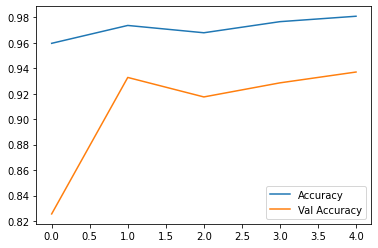

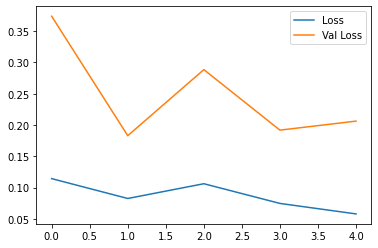

In [30]:
his = history.history

plt.plot(his["accuracy"])
plt.plot(his["val_accuracy"])
plt.legend(["Accuracy", "Val Accuracy"])
#plt.savefig("graph/accuracy_Graph.png")
plt.show()

plt.plot(his["loss"])
plt.plot(his["val_loss"])
plt.legend(["Loss", "Val Loss"])
#plt.savefig("graph/loss_Graph.png")
plt.show()

In [16]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [46]:
test_data = test_datagen.flow_from_directory(
    "test2",
    batch_size=batch_size,
    target_size=img_size,
    class_mode="binary")

Found 98 images belonging to 2 classes.


In [47]:
loss, accuracy = clf_model.evaluate(test_data)

2/2 [==============================] - 1s 472ms/step - loss: 0.3279 - accuracy: 0.9286


In [48]:
print("Loss on Test Data", loss)
print("Accuracy on Test Data", accuracy)

Loss on Test Data 0.32787051796913147
Accuracy on Test Data 0.9285714030265808


In [49]:
loss, accuracy = clf_model.evaluate(val_data)

24/24 [==============================] - 12s 505ms/step - loss: 0.1829 - accuracy: 0.9328


In [50]:
print("Loss on Validation Data", loss)
print("Accuracy on Validation Data", accuracy)

Loss on Validation Data 0.18287110328674316
Accuracy on Validation Data 0.9327659606933594


In [132]:
# Creating Json File to submit the solution
final_output = {}
for image_name in os.listdir("test"):
    img_ = image.load_img(os.path.join("test", image_name), target_size=(64, 64), color_mode="rgb")
    img_arr = image.img_to_array(img_)
    img_arr = preprocess_input(img_arr)
    img_batch = np.array([img_arr])
    output = clf_model.predict(img_batch)
    if output > 0.5:
        final_output[image_name] = 1
    else:
        final_output[image_name] = 0

In [138]:
with open("result.json", "w") as file:
    json.dump(final_output, file)